<a href="https://colab.research.google.com/github/lourencocavalcante/Neurocomputacao/blob/main/INPE_CAP351_Projeto01_MLP_Lourenco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/logoinpe.png?raw=true" width = 500 align="left">](https://www.gov.br/inpe/pt-br)

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/LogoCAP.png?raw=true" width = 300 align="right">](http://www.inpe.br/posgraduacao/cap/)

# **CAP-351 Neurocomputação**

**Professor:**
*Dr. Marcos Goncalves Quiles*

**Aluno:**
*Lourenço José Cavalcante Neto*

---

**PROPOSTA DE PROJETO 1: Experimentos com a rede Multi-layer Perceptron (MLP)**

**Descrição do projeto:**

1. Selecionar dois datasets (não triviais): Um dataset para classificação; Um dataset para regressão; Separar em treino/validação/teste.

2. Treinar modelos MLP para os dois problemas (**classificação** e **regressão**)

3. Considerar:
  * Diferentes topologias (>=5 topologias, variar número de
camadas)
  * Usar o algoritmo original SGD (não usar algoritmos otimizados,
e.g. ADAM)
  * Avaliar o impacto do uso do Momentum
  * Avaliar o impacto do uso da regularização (i.e. L2)

4. Ilustrar graficamente a evolução do treinamento (treino/validação).

5. Confeccionar um relatório (reprodutível) contendo os
experimentos e resados

# **Introdução**

A larga aplicabilidade das redes neurais se justifica pelo fato da existência de vários de modelos presentes na literatura no tocante deste tema, nas quais possuem diferentes modos, paradigmas e formas de aprendizagem. Destaca-se a rede Multilayer Perceptron, denominada por (BASHEER; HAJMEER, 2000) como o “workhorse”das redes neurais, sendo este um dos modelos mais largamente utilizado (BASHEER; HAJMEER, 2000).

No presente notebook contém diversos experimentos e testes com a rede Multi-layer Perceptron (MLP). Foi selecionado um datasets (não trivial) no qual foi divido em treino, validação e teste, e utilizado para treino de modelos MLP em dois problemas: classificação e regressão. Os Dados são de um equipamento chamado **Disdrômetro RD80** (também chamado de **Joss**). Instalado próximo à torre **ATTO**, em um sítio chamado Campina, na região Amazônica. O disdrômetro RD80 mede a distribuição das gotas de chuva que chegam à superfície.

Foram criadas 5 topologias diferentes, variando o número de camadas. O algoritmo utilizado foi SGD, e foram aplicadas diferentes hyperparâmetros afim de avaliar o impacto do uso do Momentum e da Regularização (L2).

Este notebook pode ser acessado no **github**: https://github.com/lourencocavalcante/Neurocomputacao.git

# **Bibliotecas/Pacotes**

In [ ]:
import pandas as pd

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

from keras.models import Sequential
from keras.layers import Activation, Dense

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

import datetime
import time

from google.colab import drive
drive.mount('/content/drive')

print(tf.__version__)

Mounted at /content/drive
2.8.2


# **Dataset**
 
Os Dados são de um equipamento chamado **Disdrômetro RD80** (também chamado de **Joss**). Instalado próximo à torre **ATTO**, em um sítio chamado Campina, na região amazônica, o Disdrômetro RD80 mede a distribuição das gotas de chuva que chegam à superfície. No total, o Dataset possui 06 atributos, os são listados abaixo:

```
Datetime
Rain Intensity (mm/h)
radar reflectivity (1/mm6m3)
Liquid watercontent (g/m3)
Mean weight diameter(mm)
Time integration (s)
```

*Obs.: Conforme sugerido/autorizado pelo professor Marcos na aula do dia 11/07, o mesmo Dataset será utilizado para os problemas de Classificação e Regressão.*

## **Importação, Formatação, Tratamento e Visualização dos dados**

In [ ]:
#Importando o Dataset e criando o Dataframe
df_rd80_full = pd.read_csv("/content/drive/MyDrive/MestradoCAP/Lourenco/cap351/Datasets/df_final_rd80_joss.csv")
df_rd80_full = pd.DataFrame(df_rd80_full)

#Aqui verificamos o tamanho e quantidade de atributos do Dataset
print('Tamanho do dataset: ',df_rd80_full.shape[0], ', quantidade de atributos: ', df_rd80_full.shape[1])

Tamanho do dataset:  315420 , quantidade de atributos:  6


Como podemos ver, o tamanho do nosso Dataset é de 315.420 e isso pode ocasionar um custo computacional muito alto durante os experimentos e testes do Projeto. Sendo assim, será utilizado apenas 1/3 dos dados.

In [ ]:
#Definindo uma parte do Dataset para usá-lo neste Projeto
limit_date = datetime.datetime(year=2022, month=4,day=20)

df_rd80_full = df_rd80_full.set_index('Datetime')

df_rd80 = df_rd80_full.loc[df_rd80_full.index >= str(limit_date)]
#df_rd80 = df_rd80.loc[df_rd80['Rain Intensity (mm/h)'] > 0]
df_rd80.reset_index(inplace=True)

print('Tamanho do Dataset que será utilizado: ', df_rd80.shape[0])


Tamanho do Dataset que será utilizado:  93521


In [ ]:
#Carregando o Dataset
df_rd80.loc[df_rd80['Rain Intensity (mm/h)'] > 0].head()

,Datetime,Rain Intensity (mm/h),radar reflectivity (1/mm6m3),Liquid watercontent (g/m3),Mean weight diameter(mm),Time integration (s)
560,2022-04-20 09:20:00,0.12402,26.92282,0.00925,0.98225,60.0
561,2022-04-20 09:21:00,1.55755,407.78217,0.08701,1.33388,60.0
562,2022-04-20 09:22:00,0.88193,179.50739,0.05338,1.19289,60.0
563,2022-04-20 09:23:00,1.35030,225.83681,0.08661,1.10252,60.0
564,2022-04-20 09:24:00,0.26512,39.40490,0.01808,1.02600,60.0


In [ ]:
#Normalizando os dados
#É necessário assumir que os valores para Rain Intensity (mm/h) que forem menores que 0.1 sejam considerados como 0(zero)
df_rd80['Rain Intensity (mm/h)'].loc[df_rd80['Rain Intensity (mm/h)'] < 0.1] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


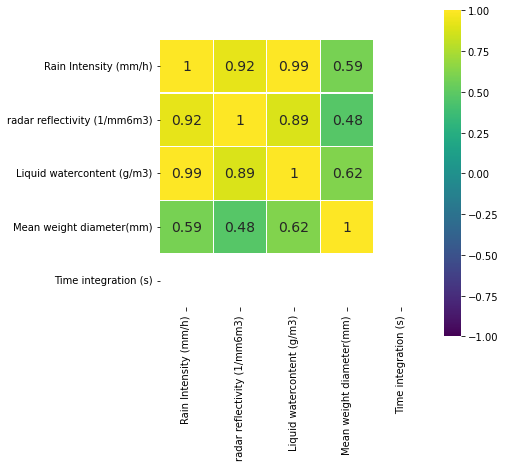

In [ ]:
#Visualizando as correlações entre as variáveis
corr = df_rd80.corr()
plt.figure(figsize=(6, 6))
sns.heatmap(corr[(corr >= 0.30) | (corr <= -0.30)],cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 14}, square=True);

[]

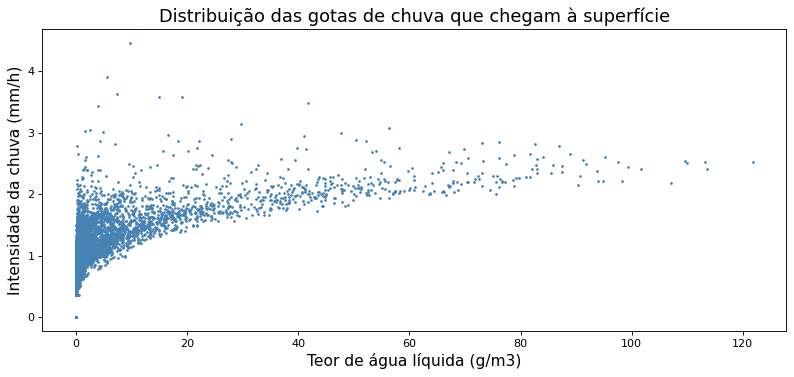

In [ ]:
figure(figsize=(12,5),dpi=80)
plt.scatter(df_rd80['Rain Intensity (mm/h)'] ,df_rd80['Mean weight diameter(mm)'],s=2, color='#4682B4')
plt.xlabel(r'Teor de água líquida (g/m3)',size=14)
plt.ylabel(r'Intensidade da chuva (mm/h)',size=14)
plt.title("Distribuição das gotas de chuva que chegam à superfície", size=16)
plt.plot()

Conforme orientações para o projeto, para realizar o treinamento e validação do aprendizado de uma rede **Multi-layer Perceptron (MLP)**, realizou-se a divisão do conjunto de dados em dois grupos: Treino (70%) e Teste (30%). A biblioteca scikit-learn nos auxiliará nesta tarefa. 

In [ ]:
#Dividindo o dataset em treino e teste
x_train, x_test, y_train, y_test = train_test_split(df_rd80['Rain Intensity (mm/h)'] ,df_rd80['Mean weight diameter(mm)'], test_size=0.24)
print('Tamanho do dataset para treinamento: ',len(x_train))
print('Tamanho do dataset para validação: ',len(x_test))

Tamanho do dataset para treinamento:  71075
Tamanho do dataset para validação:  22446


Após dividir o Dataset, inicialmente vamos checar o comportamento do dataset de Treino e de Teste da rede, para entender o que a rede buscará aprender e o que esta rede buscará prever.

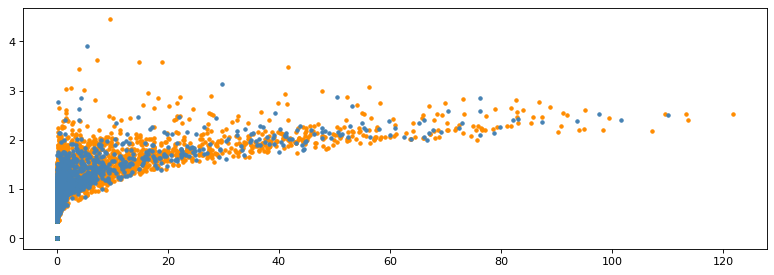

In [ ]:
figure(figsize=(12,4),dpi=80)
plt.plot(x_train, y_train, '.', color='#FF8C00', label="Dados para Treinamento")
plt.plot(x_test, y_test, '.', color='#4682B4', label="Dados para Teste")
plt.show()

# **Problema 1: Regressão**
Com o objetivo de construir uma rede capaz de encontrar uma lei de regressão para o problema, serão criadas 05(cinco) topologias de rede MLP diferentes. Buscando melhores resultados nos experimentos e testes, serão criadas 05(cinco) topologias de rede MLP diferentes, nas quais terão o número de camadas e o número de neurônios modificados em cada topologia.

## **Configurações**

* Momentum
* Regularização (L2)
* Épocas (epochs)

Antes de iniciarmos a estruturação das Topologias, vamos definir os valores para configurações dos **Hiperparâmetros do Momentum** e **Regularização (L2)** para avaliar seus impactos, e quantidade de épocas (**epochs**) para os treinos.

In [ ]:
#Configurações para avaliar o impacto do uso do Momentum e da Regularização (L2)
momentum =    [0.0, 0.2, 0.6, 0.9]
regularizer = [0.0, 0.2, 0.1, 0.0]
dropout = [0.0, 0.0, 0.0, 0.0]

#Define a quantidade de épocas para o treinamento
epochs = 100 

## **Topologia I**
Este primeiro será um caso simples e clássico de um perceptron. A rede neural que será criada  é uma MLP com 2 camadas, sendo estas a camada de entrada e a camada de saída. 




**Criação dos modelos**

In [ ]:
#Modelos da Topologia I
modelos_tpl_I = []

for res in range(0,4):
  #print(i)
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=momentum[res])
  modelos_tpl_I.append(keras.Sequential())
  modelos_tpl_I[res].add(keras.layers.Dense(units=3, kernel_regularizer=l2(regularizer[res]), input_shape=[1], activation="tanh"))
  modelos_tpl_I[res].add(keras.layers.Dense(units=1, activation="linear"))
  #tf.keras.utils.plot_model(modelos_tpl_I[res], show_shapes=True)
  modelos_tpl_I[res].compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])

**Agora vamos treinar os Modelos criados**

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

history_modelos_tpl_I = []
for res in range(0,4):
  history_modelos_tpl_I.append(modelos_tpl_I[res].fit(x_train, y_train, epochs=epochs, batch_size=10, validation_split=0.2, verbose=True)) #callbacks=[early]


**Resultados do Treinamento**

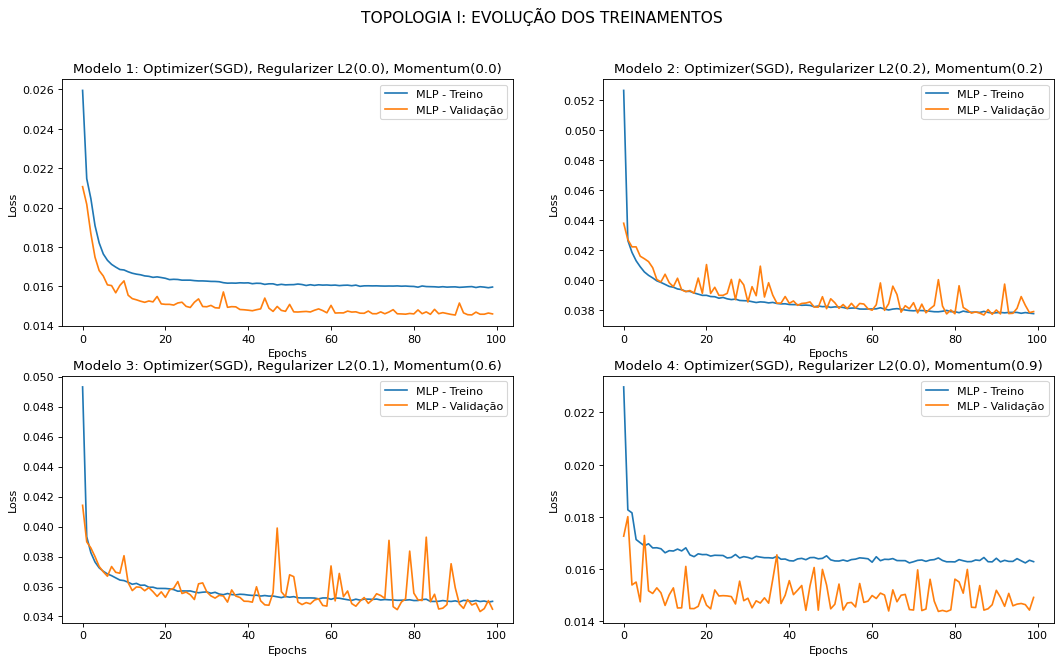

In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA I: EVOLUÇÃO DOS TREINAMENTOS', size=14)
for res in range(0,4):
    plt.subplot(2,2,res+1)
    plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(history_modelos_tpl_I[res].history['loss'], label="MLP - Treino")
    plt.plot(history_modelos_tpl_I[res].history['val_loss'], label="MLP - Validação")
    plt.legend()
plt.show()

**Avaliação**

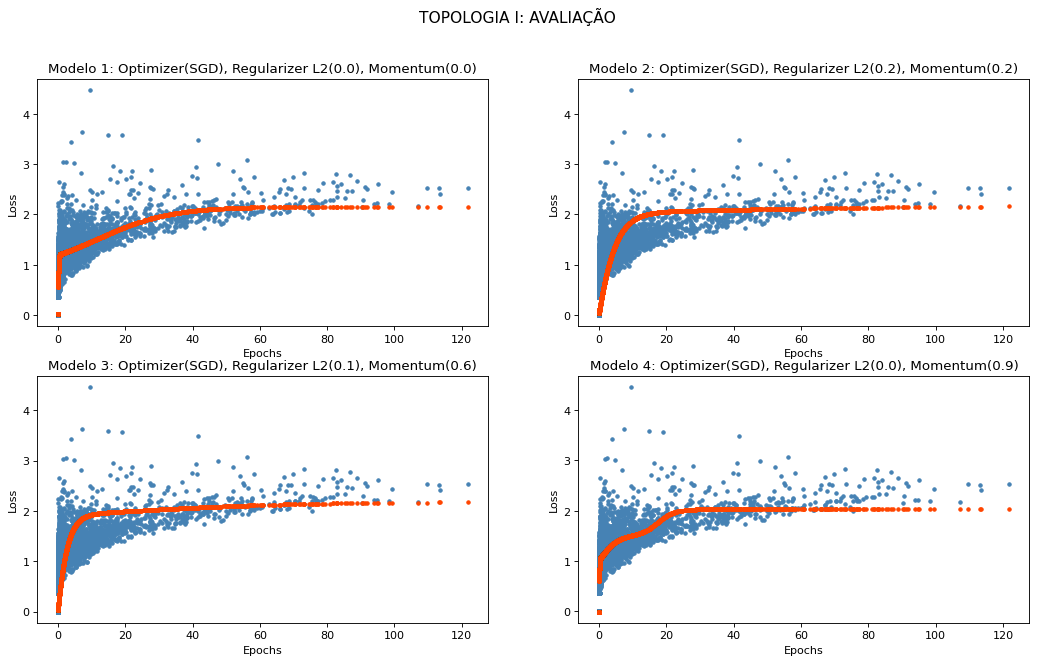

In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA I: AVALIAÇÃO', size=14)

for res in range(0,4):

  plt.subplot(2,2,res+1)
  y_rest = modelos_tpl_I[res].predict(x_train)
  plt.plot(x_train, y_train, '.', color='#4682B4')
  plt.plot(x_train, y_rest, '.',color='#FF4500')
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()

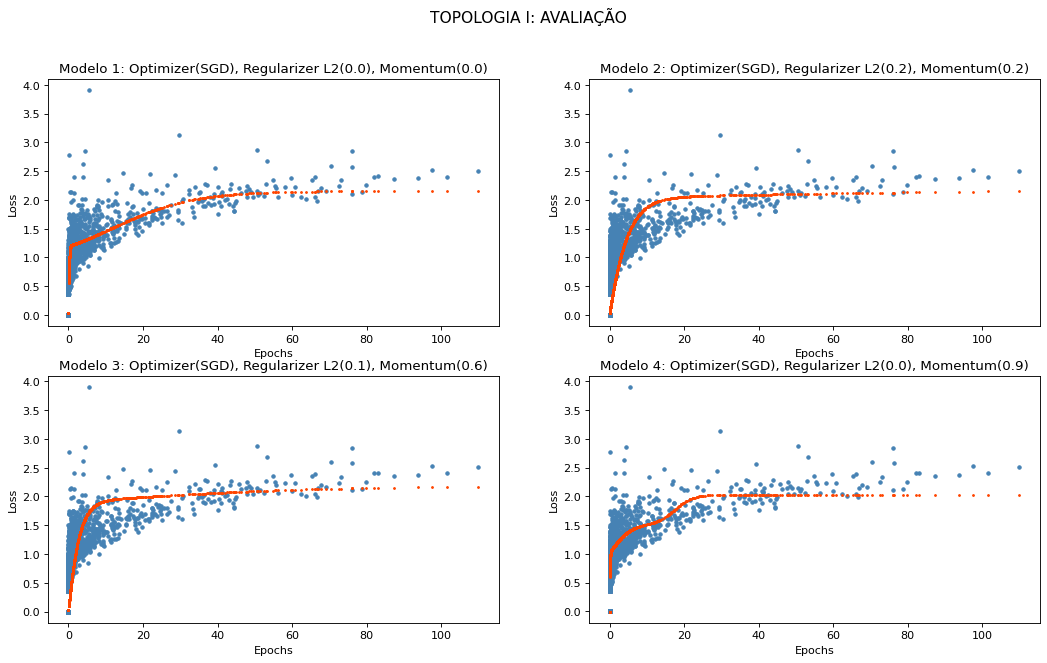

702/702 [==============================] - 1s 2ms/step - loss: 0.0154 - mean_absolute_error: 0.0352


In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA I: AVALIAÇÃO', size=14)
for res in range(0,4):

  plt.subplot(2,2,res+1)
  y_rest = modelos_tpl_I[res].predict(x_test)
  plt.plot(x_test, y_test, '.', color='#4682B4')
  plt.plot(x_test, y_rest, '.', markersize=3 ,color='#FF4500')
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()


for res in range(0,4):
  test_loss = modelos_tpl_I[res].evaluate(x_test, y_test)

In [ ]:
score_modelos_tpl_I = []
for res in range(0,4): 
  score_modelos_tpl_I.append(modelos_tpl_I[res].evaluate(x_test, y_test, verbose=0))
  print('Topologia I - Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  print('Teste loss:',   score_modelos_tpl_I[res][0])
  print('Teste métricas:', score_modelos_tpl_I[res][1])
  print('----------------------------------------')

Topologia I - Modelo 1: Optimizer(SGD), Regularizer L2(0.0), Momentum(0.0)
Teste loss: 0.015102862380445004
Teste métricas: 0.0542958527803421
----------------------------------------
Topologia I - Modelo 2: Optimizer(SGD), Regularizer L2(0.2), Momentum(0.2)
Teste loss: 0.03589485585689545
Teste métricas: 0.07782171666622162
----------------------------------------
Topologia I - Modelo 3: Optimizer(SGD), Regularizer L2(0.1), Momentum(0.6)
Teste loss: 0.03282322734594345
Teste métricas: 0.0674511268734932
----------------------------------------
Topologia I - Modelo 4: Optimizer(SGD), Regularizer L2(0.0), Momentum(0.9)
Teste loss: 0.015431072562932968
Teste métricas: 0.03523930162191391
----------------------------------------




---



## **Topologia II**

A rede neural que será criada será uma MLP com 5 camadas, sendo:
*   01 camada de entrada (input layer) com 20 Neurônios
*   01 camada escondida (hidden layer) com 20 Neurônios
*   01 camada escondida (hidden layer) com 10 Neurônios
*   01 camada escondida (hidden layer) com 5 Neurônios
*   01 camada de saída (output layer) com 1 Neurônio

**Criação do Modelos**

In [ ]:
#Modelos da Topologia II
mdl_tpl_II = []

for res in range(0,4):
  #print(i)
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=momentum[res])
  mdl_tpl_II.append(keras.Sequential())
  mdl_tpl_II[res].add(keras.layers.Dense(units=20,  kernel_regularizer=l2(regularizer[res]), input_shape=[1], activation="tanh"))
  mdl_tpl_II[res].add(keras.layers.Dense(units=20,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_II[res].add(keras.layers.Dense(units=10,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_II[res].add(keras.layers.Dense(units=5,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_II[res].add(keras.layers.Dense(units=1,  activation="linear"))
  #tf.keras.utils.plot_model(mdl_tpl_II[res], show_shapes=True)
  mdl_tpl_II[res].compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])

**Agora vamos treinar os Modelos criados**

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

history_mdl_tpl_II = []
for res in range(0,4):
  history_mdl_tpl_II.append(mdl_tpl_II[res].fit(x_train, y_train, epochs=epochs, batch_size=10, validation_split=0.2, verbose=True)) #callbacks=[early]


**Resultados do Treinamento**

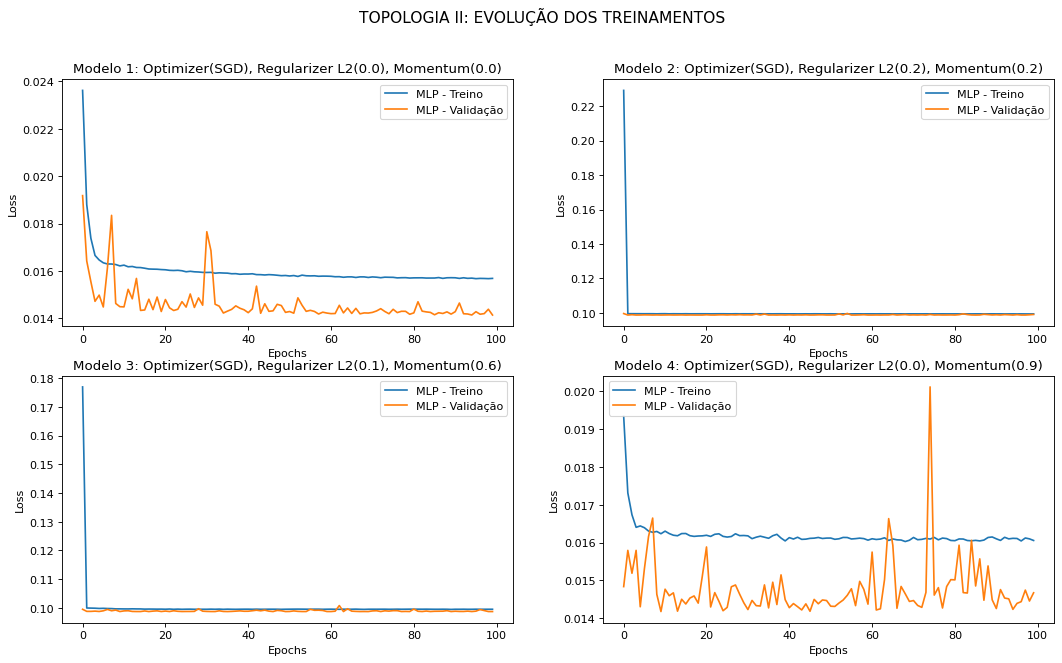

In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA II: EVOLUÇÃO DOS TREINAMENTOS', size=14)
for res in range(0,4):
    plt.subplot(2,2,res+1)
    plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(history_mdl_tpl_II[res].history['loss'], label="MLP - Treino")
    plt.plot(history_mdl_tpl_II[res].history['val_loss'], label="MLP - Validação")
    plt.legend()
plt.show()

**Avaliação**

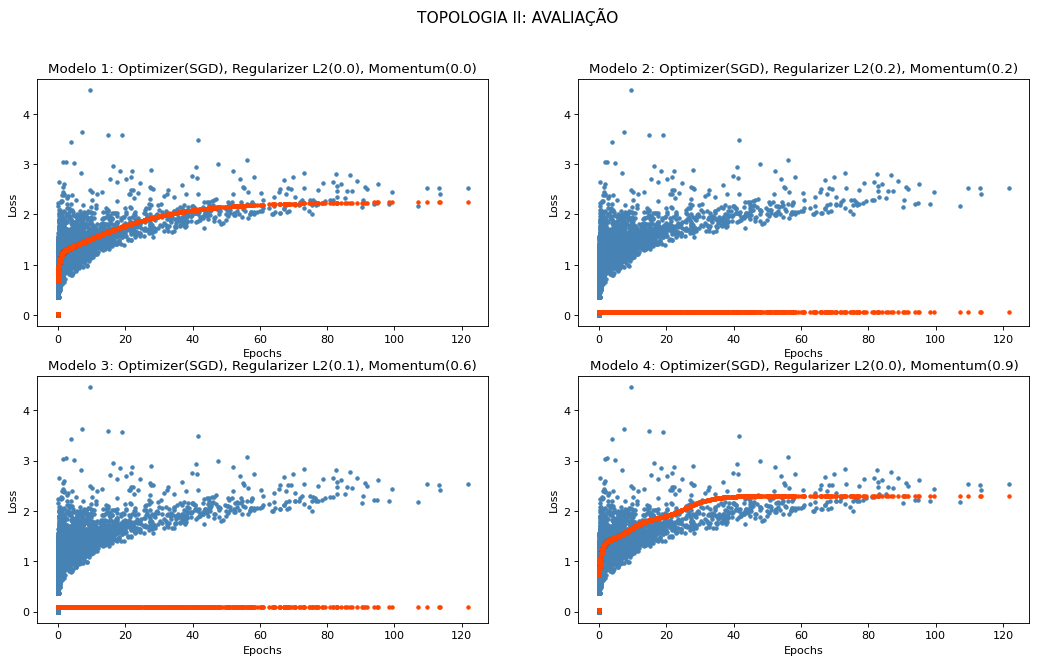

In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA II: AVALIAÇÃO', size=14)

for res in range(0,4):

  plt.subplot(2,2,res+1)
  y_rest = mdl_tpl_II[res].predict(x_train)
  plt.plot(x_train, y_train, '.', color='#4682B4')
  plt.plot(x_train, y_rest, '.',color='#FF4500')
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()

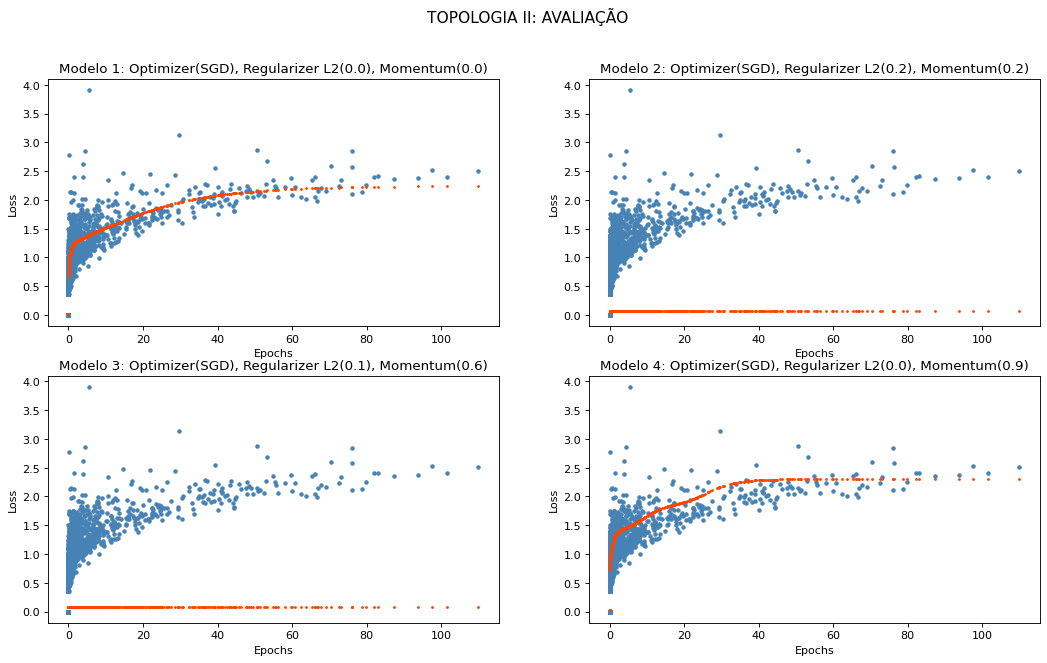

702/702 [==============================] - 1s 2ms/step - loss: 0.0151 - mean_absolute_error: 0.0569


In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA II: AVALIAÇÃO', size=14)
for res in range(0,4):

  plt.subplot(2,2,res+1)
  y_rest = mdl_tpl_II[res].predict(x_test)
  plt.plot(x_test, y_test, '.', color='#4682B4')
  plt.plot(x_test, y_rest, '.', markersize=3 ,color='#FF4500')
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()


for res in range(0,4):
  test_loss = mdl_tpl_II[res].evaluate(x_test, y_test)

In [ ]:
score_mdl_tpl_II = []
for res in range(0,4): 
  score_mdl_tpl_II.append(mdl_tpl_II[res].evaluate(x_test, y_test, verbose=0))
  print('Topologia II - Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  print('Teste loss:',   score_mdl_tpl_II[res][0])
  print('Teste métricas:', score_mdl_tpl_II[res][1])
  print('----------------------------------------')

Topologia II - Modelo 1: Optimizer(SGD), Regularizer L2(0.0), Momentum(0.0)
Teste loss: 0.014566567726433277
Teste métricas: 0.04911044239997864
----------------------------------------
Topologia II - Modelo 2: Optimizer(SGD), Regularizer L2(0.2), Momentum(0.2)
Teste loss: 0.09663590788841248
Teste métricas: 0.1404242068529129
----------------------------------------
Topologia II - Modelo 3: Optimizer(SGD), Regularizer L2(0.1), Momentum(0.6)
Teste loss: 0.09643939882516861
Teste métricas: 0.15537969768047333
----------------------------------------
Topologia II - Modelo 4: Optimizer(SGD), Regularizer L2(0.0), Momentum(0.9)
Teste loss: 0.015124398283660412
Teste métricas: 0.05690271407365799
----------------------------------------




---



## **Topologia III**

A rede neural que será criada será uma MLP com 5 camadas, sendo:
*   01 camada de entrada (input layer) com 40 Neurônios
*   01 camada escondida (hidden layer) com 40 Neurônios
*   01 camada escondida (hidden layer) com 20 Neurônios
*   01 camada escondida (hidden layer) com 10 Neurônios
*   01 camada de saída (output layer) com 1 Neurônio

**Criação do Modelos**

In [ ]:
#Modelos da Topologia III
mdl_tpl_III = []

for res in range(0,4):
  #print(i)
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=momentum[res])
  mdl_tpl_III.append(keras.Sequential())
  mdl_tpl_III[res].add(keras.layers.Dense(units=40,  kernel_regularizer=l2(regularizer[res]), input_shape=[1], activation="tanh"))
  mdl_tpl_III[res].add(keras.layers.Dense(units=40,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_III[res].add(keras.layers.Dense(units=20,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_III[res].add(keras.layers.Dense(units=10,  activation="tanh"))
  mdl_tpl_III[res].add(keras.layers.Dense(units=1,  activation="linear"))
  #tf.keras.utils.plot_model(mdl_tpl_III[res], show_shapes=True)
  mdl_tpl_III[res].compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])

**Agora vamos treinar os Modelos criados**

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

history_mdl_tpl_III = []
for res in range(0,4):
  history_mdl_tpl_III.append(mdl_tpl_III[res].fit(x_train, y_train, epochs=epochs, batch_size=10, validation_split=0.2, verbose=True)) #callbacks=[early]


**Resultados do Treinamento**

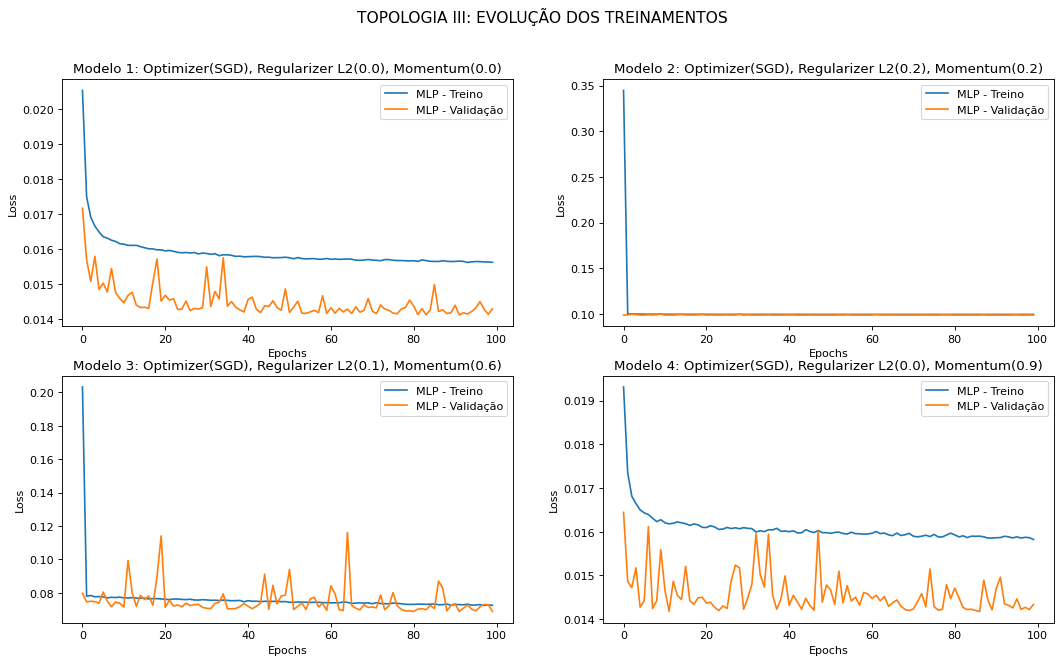

In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA III: EVOLUÇÃO DOS TREINAMENTOS', size=14)
for res in range(0,4):
    plt.subplot(2,2,res+1)
    plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(history_mdl_tpl_III[res].history['loss'], label="MLP - Treino")
    plt.plot(history_mdl_tpl_III[res].history['val_loss'], label="MLP - Validação")
    plt.legend()
plt.show()

**Avaliação**

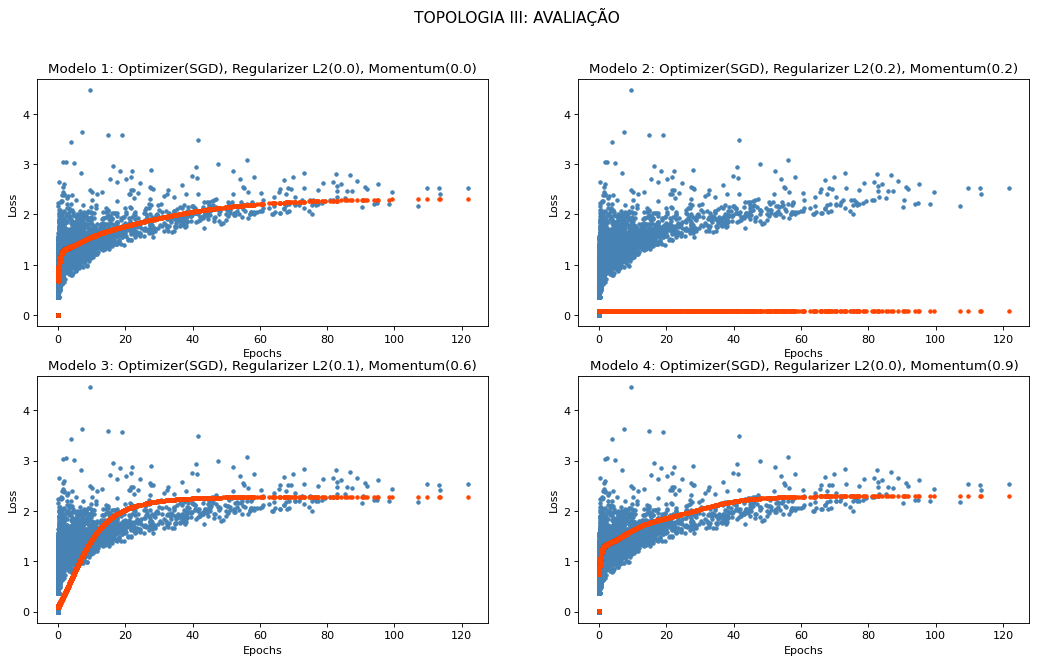

In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA III: AVALIAÇÃO', size=14)

for res in range(0,4):

  plt.subplot(2,2,res+1)
  y_rest = mdl_tpl_III[res].predict(x_train)
  plt.plot(x_train, y_train, '.', color='#4682B4')
  plt.plot(x_train, y_rest, '.',color='#FF4500')
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()

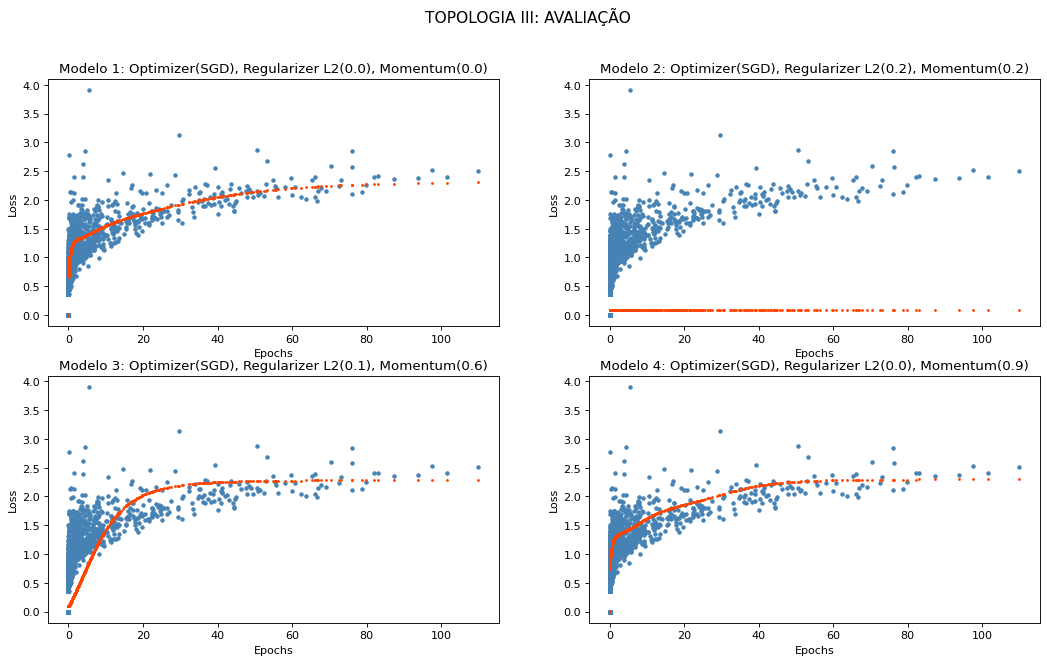

702/702 [==============================] - 1s 2ms/step - loss: 0.0148 - mean_absolute_error: 0.0418


In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA III: AVALIAÇÃO', size=14)
for res in range(0,4):

  plt.subplot(2,2,res+1)
  y_rest = mdl_tpl_III[res].predict(x_test)
  plt.plot(x_test, y_test, '.', color='#4682B4')
  plt.plot(x_test, y_rest, '.', markersize=3 ,color='#FF4500')
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()


for res in range(0,4):
  test_loss = mdl_tpl_III[res].evaluate(x_test, y_test)

In [ ]:
score_mdl_tpl_III = []
for res in range(0,4): 
  score_mdl_tpl_III.append(mdl_tpl_III[res].evaluate(x_test, y_test, verbose=0))
  print('Topologia III - Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  print('Teste loss:',   score_mdl_tpl_III[res][0])
  print('Teste métricas:', score_mdl_tpl_III[res][1])
  print('----------------------------------------')

Topologia III - Modelo 1: Optimizer(SGD), Regularizer L2(0.0), Momentum(0.0)
Teste loss: 0.014757014811038971
Teste métricas: 0.036966074258089066
----------------------------------------
Topologia III - Modelo 2: Optimizer(SGD), Regularizer L2(0.2), Momentum(0.2)
Teste loss: 0.09645631164312363
Teste métricas: 0.15689285099506378
----------------------------------------
Topologia III - Modelo 3: Optimizer(SGD), Regularizer L2(0.1), Momentum(0.6)
Teste loss: 0.06581734120845795
Teste métricas: 0.1310119479894638
----------------------------------------
Topologia III - Modelo 4: Optimizer(SGD), Regularizer L2(0.0), Momentum(0.9)
Teste loss: 0.014787127263844013
Teste métricas: 0.04179390147328377
----------------------------------------




---



## **Topologia IV**

A rede neural que será criada será uma MLP com 6 camadas, sendo:
*   01 camada de entrada (input layer) com 50 Neurônios
*   01 camada escondida (hidden layer) com 50 Neurônios
*   01 camada escondida (hidden layer) com 20 Neurônios
*   01 camada escondida (hidden layer) com 10 Neurônios
*   01 camada escondida (hidden layer) com 5 Neurônios
*   01 camada de saída (output layer) com 1 Neurônio

**Criação do Modelos**

In [ ]:
#Modelos da Topologia IV
mdl_tpl_IV = []

for res in range(0,4):
  #print(i)
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=momentum[res])
  mdl_tpl_IV.append(keras.Sequential())
  mdl_tpl_IV[res].add(keras.layers.Dense(units=50,  kernel_regularizer=l2(regularizer[res]), input_shape=[1], activation="tanh"))
  mdl_tpl_IV[res].add(keras.layers.Dense(units=50,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_IV[res].add(keras.layers.Dense(units=20,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_IV[res].add(keras.layers.Dense(units=10,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_IV[res].add(keras.layers.Dense(units=5,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_IV[res].add(keras.layers.Dense(units=1, activation="linear"))
  #tf.keras.utils.plot_model(mdl_tpl_IV[res], show_shapes=True)
  mdl_tpl_IV[res].compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])

**Agora vamos treinar os Modelos criados**

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

history_mdl_tpl_IV = []
for res in range(0,4):
  history_mdl_tpl_IV.append(mdl_tpl_IV[res].fit(x_train, y_train, epochs=epochs, batch_size=10, validation_split=0.2, verbose=True)) #callbacks=[early]


**Resultados do Treinamento**

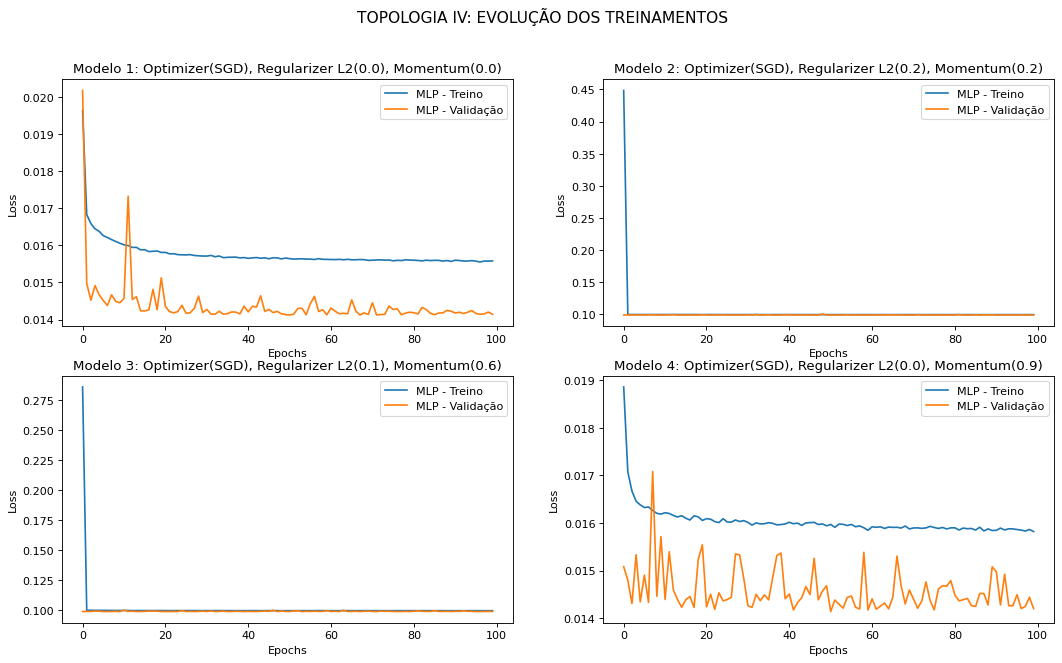

In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA IV: EVOLUÇÃO DOS TREINAMENTOS', size=14)
for res in range(0,4):
    plt.subplot(2,2,res+1)
    plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(history_mdl_tpl_IV[res].history['loss'], label="MLP - Treino")
    plt.plot(history_mdl_tpl_IV[res].history['val_loss'], label="MLP - Validação")
    plt.legend()
plt.show()

**Avaliação**

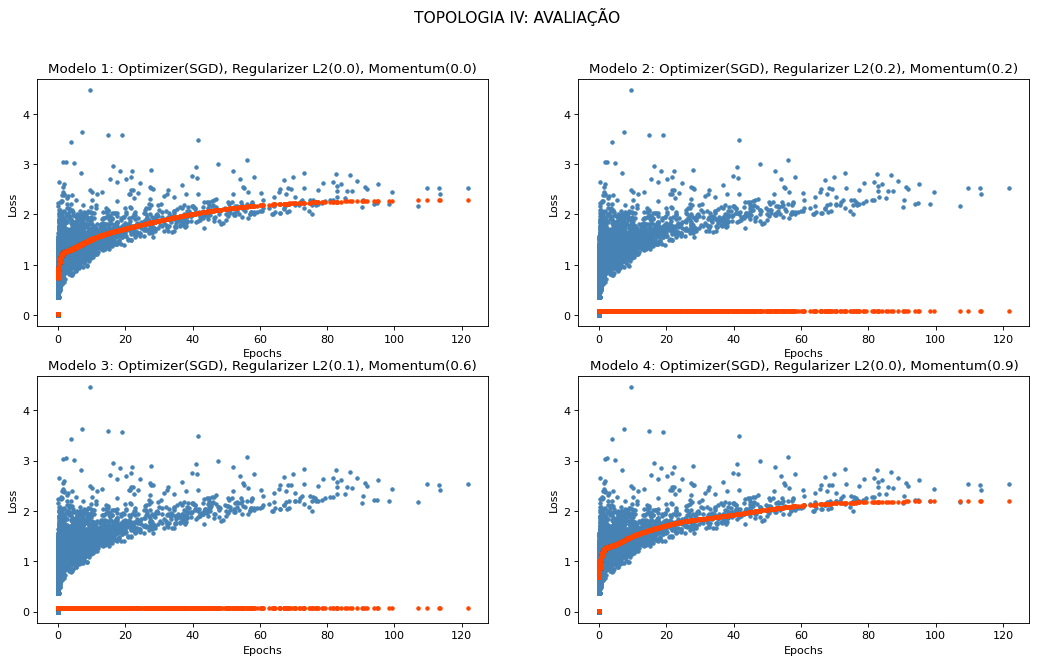

In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA IV: AVALIAÇÃO', size=14)

for res in range(0,4):

  plt.subplot(2,2,res+1)
  y_rest = mdl_tpl_IV[res].predict(x_train)
  plt.plot(x_train, y_train, '.', color='#4682B4')
  plt.plot(x_train, y_rest, '.',color='#FF4500')
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()

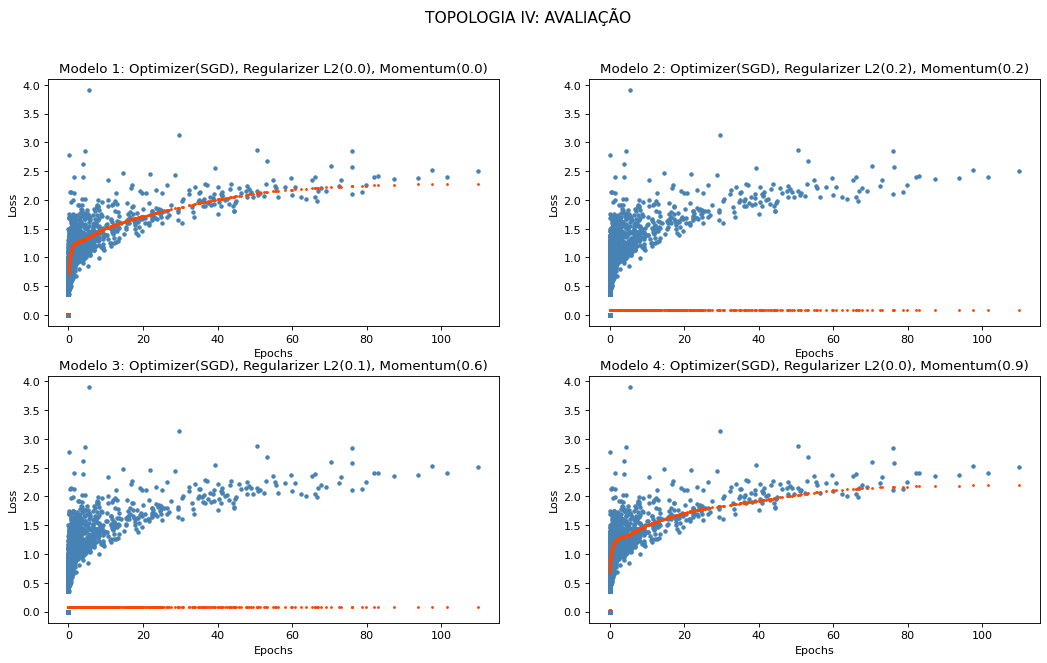

702/702 [==============================] - 1s 2ms/step - loss: 0.0146 - mean_absolute_error: 0.0463


In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA IV: AVALIAÇÃO', size=14)
for res in range(0,4):

  plt.subplot(2,2,res+1)
  y_rest = mdl_tpl_IV[res].predict(x_test)
  plt.plot(x_test, y_test, '.', color='#4682B4')
  plt.plot(x_test, y_rest, '.', markersize=3 ,color='#FF4500')
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()


for res in range(0,4):
  test_loss = mdl_tpl_IV[res].evaluate(x_test, y_test)

In [ ]:
score_mdl_tpl_IV = []
for res in range(0,4): 
  score_mdl_tpl_IV.append(mdl_tpl_IV[res].evaluate(x_test, y_test, verbose=0))
  print('Topologia III - Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  print('Teste loss:',   score_mdl_tpl_IV[res][0])
  print('Teste métricas:', score_mdl_tpl_IV[res][1])
  print('----------------------------------------')

Topologia III - Modelo 1: Optimizer(SGD), Regularizer L2(0.0), Momentum(0.0)
Teste loss: 0.014567194506525993
Teste métricas: 0.04448413476347923
----------------------------------------
Topologia III - Modelo 2: Optimizer(SGD), Regularizer L2(0.2), Momentum(0.2)
Teste loss: 0.09644532203674316
Teste métricas: 0.14870159327983856
----------------------------------------
Topologia III - Modelo 3: Optimizer(SGD), Regularizer L2(0.1), Momentum(0.6)
Teste loss: 0.09646741300821304
Teste métricas: 0.1470356285572052
----------------------------------------
Topologia III - Modelo 4: Optimizer(SGD), Regularizer L2(0.0), Momentum(0.9)
Teste loss: 0.01464962400496006
Teste métricas: 0.04633164033293724
----------------------------------------


## **Topologia V**

A rede neural que será criada será uma MLP com 6 camadas, sendo:
*   01 camada de entrada (input layer) com 100 Neurônios
*   01 camada escondida (hidden layer) com 100 Neurônios
*   01 camada escondida (hidden layer) com 50 Neurônios
*   01 camada escondida (hidden layer) com 40 Neurônios
*   01 camada escondida (hidden layer) com 20 Neurônios
*   01 camada de saída (output layer) com 1 Neurônio

**Criação do Modelos**

In [ ]:
#Modelos da Topologia V
mdl_tpl_V = []

for res in range(0,4):
  #print(i)
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=momentum[res])
  mdl_tpl_V.append(keras.Sequential())
  mdl_tpl_V[res].add(keras.layers.Dense(units=100,  kernel_regularizer=l2(regularizer[res]), input_shape=[1], activation="tanh"))
  mdl_tpl_V[res].add(Dropout(dropout[res]))
  mdl_tpl_V[res].add(keras.layers.Dense(units=100,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_V[res].add(Dropout(dropout[res]))
  mdl_tpl_V[res].add(keras.layers.Dense(units=50,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_V[res].add(Dropout(dropout[res]))
  mdl_tpl_V[res].add(keras.layers.Dense(units=40,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_V[res].add(Dropout(dropout[res]))
  mdl_tpl_V[res].add(keras.layers.Dense(units=20,  kernel_regularizer=l2(regularizer[res]), activation="tanh"))
  mdl_tpl_V[res].add(keras.layers.Dense(units=1, activation="linear"))
  #tf.keras.utils.plot_model(mdl_tpl_V[res], show_shapes=True)
  mdl_tpl_V[res].compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])

**Agora vamos treinar os Modelos criados**

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

history_mdl_tpl_V = []
for res in range(0,4):
  history_mdl_tpl_V.append(mdl_tpl_V[res].fit(x_train, y_train, epochs=epochs, batch_size=10, validation_split=0.2, verbose=True)) #callbacks=[early]


**Resultados do Treinamento**

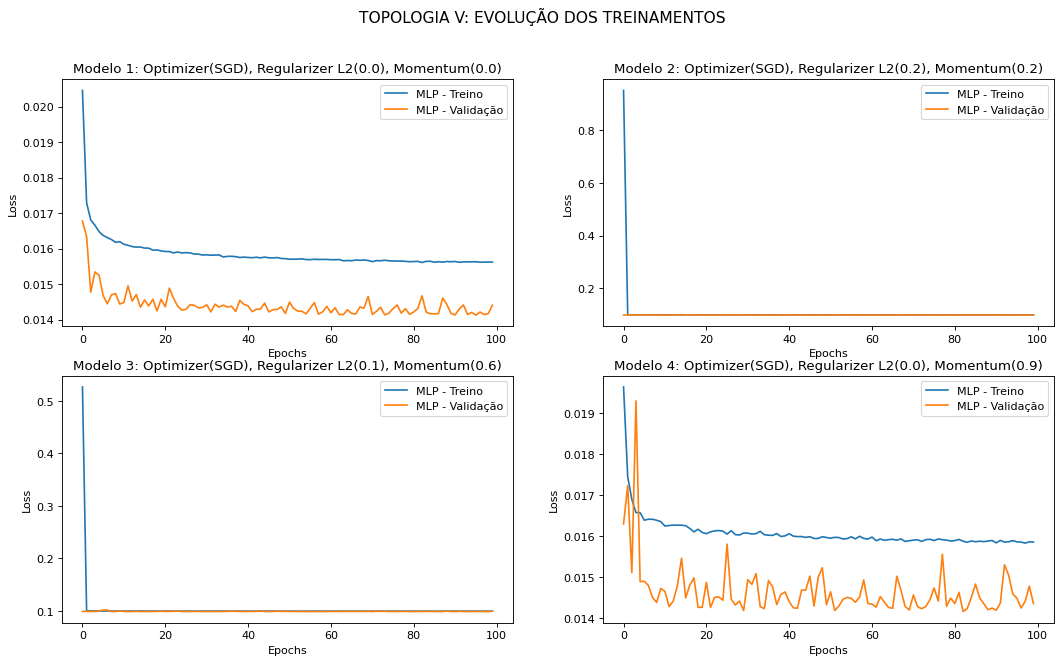

In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA V: EVOLUÇÃO DOS TREINAMENTOS', size=14)
for res in range(0,4):
    plt.subplot(2,2,res+1)
    plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(history_mdl_tpl_V[res].history['loss'], label="MLP - Treino")
    plt.plot(history_mdl_tpl_V[res].history['val_loss'], label="MLP - Validação")
    plt.legend()
plt.show()

**Avaliação**

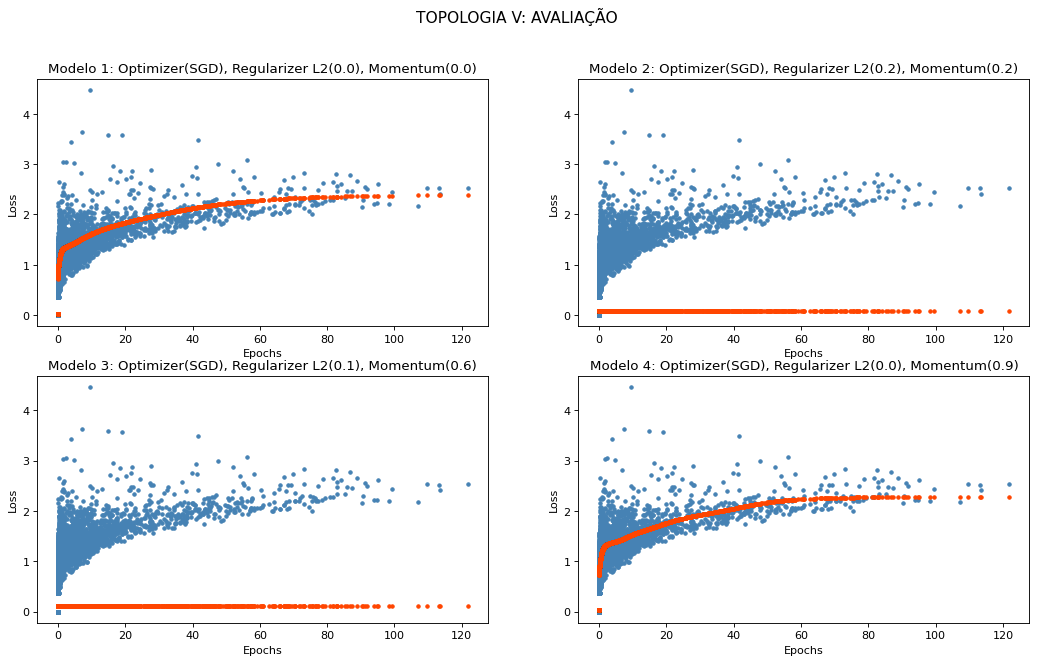

In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA V: AVALIAÇÃO', size=14)

for res in range(0,4):

  plt.subplot(2,2,res+1)
  y_rest = mdl_tpl_V[res].predict(x_train)
  plt.plot(x_train, y_train, '.', color='#4682B4')
  plt.plot(x_train, y_rest, '.',color='#FF4500')
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()

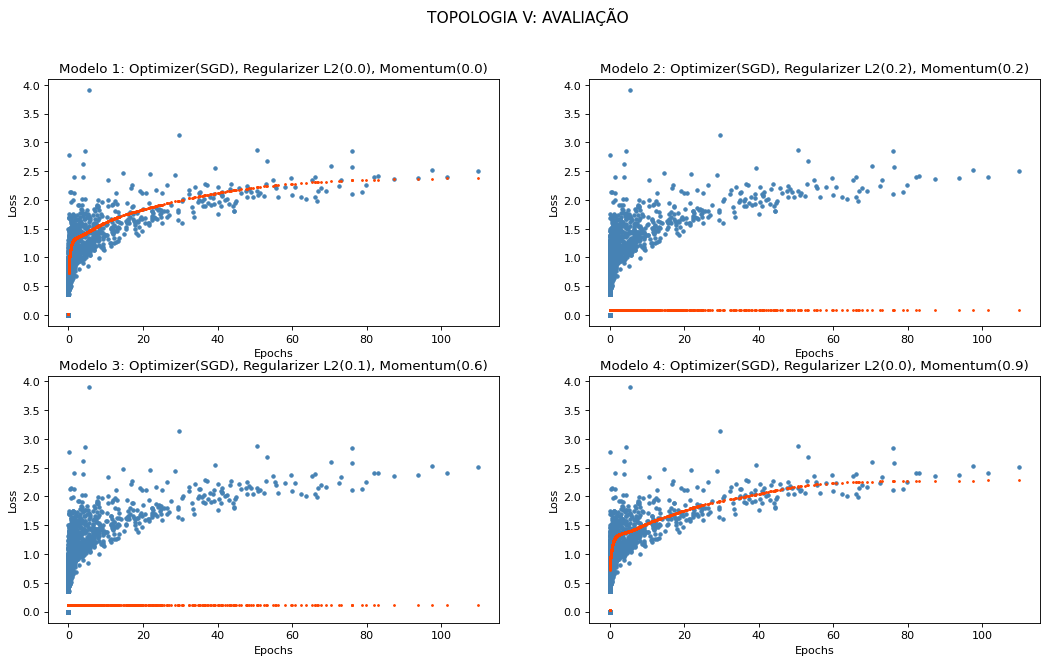

702/702 [==============================] - 1s 2ms/step - loss: 0.0148 - mean_absolute_error: 0.0594


In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA V: AVALIAÇÃO', size=14)
for res in range(0,4):

  plt.subplot(2,2,res+1)
  y_rest = mdl_tpl_V[res].predict(x_test)
  plt.plot(x_test, y_test, '.', color='#4682B4')
  plt.plot(x_test, y_rest, '.', markersize=3 ,color='#FF4500')
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.show()


for res in range(0,4):
  test_loss = mdl_tpl_V[res].evaluate(x_test, y_test)

In [ ]:
score_mdl_tpl_V = []
for res in range(0,4): 
  score_mdl_tpl_V.append(mdl_tpl_V[res].evaluate(x_test, y_test, verbose=0))
  print('Topologia III - Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  print('Teste loss:',   score_mdl_tpl_V[res][0])
  print('Teste métricas:', score_mdl_tpl_V[res][1])
  print('----------------------------------------')

Topologia III - Modelo 1: Optimizer(SGD), Regularizer L2(0.0), Momentum(0.0)
Teste loss: 0.01486779935657978
Teste métricas: 0.04586555063724518
----------------------------------------
Topologia III - Modelo 2: Optimizer(SGD), Regularizer L2(0.2), Momentum(0.2)
Teste loss: 0.09643231332302094
Teste métricas: 0.15024243295192719
----------------------------------------
Topologia III - Modelo 3: Optimizer(SGD), Regularizer L2(0.1), Momentum(0.6)
Teste loss: 0.09728213399648666
Teste métricas: 0.17640607059001923
----------------------------------------
Topologia III - Modelo 4: Optimizer(SGD), Regularizer L2(0.0), Momentum(0.9)
Teste loss: 0.014783552847802639
Teste métricas: 0.05939670279622078
----------------------------------------




---





---



# **Problema 2: Classificação**

Para este problema, o objetivo é construir uma rede capaz resolver um problema de classificação. Em Machine Learning, classificação consiste em separar um determinado grupo de informações pertencentes a uma determinada classe. Ou seja, buscarei criar um hiperplano de como distribuir um conjunto de dados temporal.

Buscando melhores resultados nos experimentos e testes, serão criadas 05(cinco) topologias de rede MLP diferentes, nas quais terão o número de camadas e o número de neurônios modificados em cada topologia.

# **Bibliotecas/Pacotes**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

from keras.models import Sequential
from keras.layers import Activation, Dense
import seaborn as sns
import numpy as np
from xgboost import XGBClassifier
import time

# **Dataset**

Como mencionado anteriormente, no problema de **Classificação** será utilizado o mesmo Dataset do problema de **Regressão**. Ou seja, dados do instrumento **Disdrômetro RD80**, tal qual está instalado nas proximidades da torre **ATTO**, em um sítio chamado Campina, na região amazônica. Ele mede a distribuição das gotas de chuva que chegam à superfície, tornado possível, a partir dos valores do atributo ***Rain Intensity (mm/h)*** se houve ou não a ocorrência de chuva e a intensidade da mesma.

Intensidade da chuva, com base no atributo **Rain Intensity (mm/h):**

* Chuva fraca 0.1-2.5mm/h;
* Chuva moderada >2.5 - 10mm/h;
* Chuva forte >10 - 50mm/h;
* Chuva muito forte >50mm/h
* Não choveu 0mm/h

## **Importação, Formatação, Tratamento e Visualização dos dados**

In [ ]:
#Importando o Dataset e criando o Dataframe
df_rd80_full = pd.read_csv("/content/drive/MyDrive/MestradoCAP/Lourenco/cap351/Datasets/df_final_rd80_joss.csv")
df_rd80_full = pd.DataFrame(df_rd80_full)

#Aqui verificamos o tamanho e quantidade de atributos do Dataset
print('Tamanho do dataset: ',df_rd80_full.shape[0], ', quantidade de atributos: ', df_rd80_full.shape[1])

Tamanho do dataset:  315420 , quantidade de atributos:  6


In [ ]:
#Definindo uma parte do Dataset para usá-lo neste Projeto
limit_date = datetime.datetime(year=2022, month=4,day=1)

df_rd80_full = df_rd80_full.set_index('Datetime')

df_rd80_full = df_rd80_full.loc[df_rd80_full.index >= str(limit_date)]
#df_rd80 = df_rd80.loc[df_rd80['Rain Intensity (mm/h)'] > 0]
df_rd80_full.reset_index(inplace=True)

print('Tamanho do Dataset que será utilizado: ', df_rd80_full.shape[0])

Tamanho do Dataset que será utilizado:  120881


In [ ]:
#Esta Função poderá ser utilizada para definir no Dataset qual a intensidade da chuva registrada.
'''
def fun_Rain_Intensity():
  start_time = time()

  for res in df_rd80_classif['Rain Intensity (mm/h)']:
    if (res >= 0.1) and (res <= 2.5):
      df_rd80_classif['intensity_of_rain'] = 'Chuva Fraca'
    elif(res > 2.5) and (res <= 10):
      df_rd80_classif['intensity_of_rain'] = 'Chuva Moderada'
    elif (res > 10) and (res <= 50):
      df_rd80_classif['intensity_of_rain'] = "Chuva Forte"
    elif (res > 50):
      df_rd80_classif['intensity_of_rain'] = "Chuva Muito Forte"
    else:
      df_rd80_classif['intensity_of_rain'] = "Sem chuva"

  instante_final = time()
'''

Vamos visualizar novamente nosso Dataset

In [ ]:
df_rd80_full.head(n=5)

,Datetime,Rain Intensity (mm/h),radar reflectivity (1/mm6m3),Liquid watercontent (g/m3),Mean weight diameter(mm),Time integration (s)
0,2022-04-01 00:00:00,0.0,0.07956,0.00090,0.359,60.0
1,2022-04-01 00:01:00,0.0,0.06465,0.00073,0.359,60.0
2,2022-04-01 00:02:00,0.0,0.09448,0.00107,0.359,60.0
3,2022-04-01 00:03:00,0.0,0.12929,0.00146,0.359,60.0
4,2022-04-01 00:04:00,0.0,0.09945,0.00113,0.359,60.0


In [ ]:
df_rd80_full.dtypes

Datetime                         object
Rain Intensity (mm/h)           float64
radar reflectivity (1/mm6m3)    float64
Liquid watercontent (g/m3)      float64
Mean weight diameter(mm)        float64
Time integration (s)            float64
dtype: object

**Definição das Classes:** Como vimos, temos 6 atributos no Dataset, mas ainda não é possível saber se houve ou não a ocorrência de chuva, olhando os dados da forma que estão. Para facilitar, vamos adicionar mais um atributo que chamaremos de **Rain** (Chuva, em português), tal qual seus valores serão com base nos valores de **Rain Intensity (mm/h)**. Será atibuído o valor *True* para **Rain** quando Rain Intensity (mm/h) for maior que 0 (zero), e caso contrário será *False*. Assim teremos duas classes: 

* True - Indicando que CHOVEU
* False - Indicando que NÃO CHOVEU

In [ ]:
df_rd80_full['Rain'] = ["True" if value > 0 else "False" for value in df_rd80_full['Rain Intensity (mm/h)']]
                    

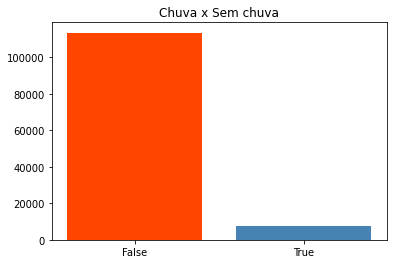

In [ ]:
freq = df_rd80_full['Rain'].value_counts() 
x=[1,2]
plt.title('Chuva x Sem chuva')
plt.bar(x,height=[freq[0],freq[1]], color=['#FF4500','#4682B4'])
plt.xticks(x, ('False','True'))
plt.show()

In [ ]:
df_rd80_full.drop(['Datetime','Time integration (s)'], axis=1, inplace=True)

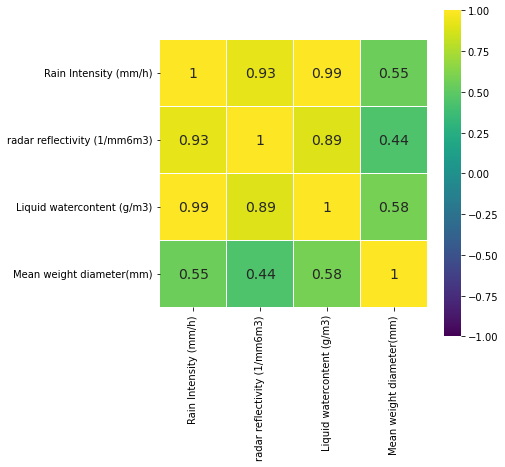

In [ ]:
#Visualizando as correlações entre as variáveis
corr = df_rd80_full.corr()
plt.figure(figsize=(6, 6))
sns.heatmap(corr[(corr >= 0.30) | (corr <= -0.30)],cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 14}, square=True);

In [ ]:
#Definições para a estrutura de classificação
df_rd80_alvos = df_rd80_full['Rain']
df_rd80_recursos = df_rd80_full.drop('Rain', axis=1)
df_rd80_alvos.value_counts()

False    113467
True       7414
Name: Rain, dtype: int64

In [ ]:
#Normalização do dados
scaler = MinMaxScaler() 
df_rd80_recursos = pd.DataFrame(scaler.fit_transform(df_rd80_recursos), columns=df_rd80_recursos.columns)
df_rd80_recursos.head()

,Rain Intensity (mm/h),radar reflectivity (1/mm6m3),Liquid watercontent (g/m3),Mean weight diameter(mm)
0,0.0,4.167260e-07,0.000193,0.080436
1,0.0,3.386291e-07,0.000157,0.080436
2,0.0,4.948752e-07,0.000230,0.080436
3,0.0,6.772059e-07,0.000313,0.080436
4,0.0,5.209075e-07,0.000242,0.080436


Com nossos dados já tratados/normalizados, agora vamos dividí-lo em: Dados de treinamento e Dados teste.

In [ ]:
#Método aplicado para corrigir um problema no treinamento do dado "Rain" devido ao seu formato True/False, tal qual é foi aceito para "binary_crossentropy"
lb = LabelEncoder()
df_rd80_full['Rain'] = lb.fit_transform(df_rd80_full['Rain'])

In [ ]:
#Dividindo o dataset

x_train_rain, x_test_rain, y_train_rain, y_test_rain = train_test_split(df_rd80_recursos , df_rd80_full['Rain'], random_state=42, test_size=0.26)
print('Tamanho do dataset para treinamento: ',len(x_train_rain))
print('Tamanho do dataset para validação: ',len(x_test_rain))

Tamanho do dataset para treinamento:  89451
Tamanho do dataset para validação:  31430


## **Configurações**

* Momentum
* Regularização (L2)
* Épocas (epochs)

Antes de iniciarmos a estruturação das Topologias, vamos definir os valores para configurações dos **Hiperparâmetros do Momentum** e **Regularização (L2)** para avaliar seus impactos, e quantidade de épocas (**epochs**) para os treinos.

In [ ]:
#Configurações para avaliar o impacto do uso do Momentum e da Regularização (L2)
momentum =    [0.0, 0.2, 0.6, 0.9]
regularizer = [0.0, 0.2, 0.1, 0.0]

#Define a quantidade de épocas para o treinamento
epochs = 100 

## **Topologia I**
A rede neural que será criada  é uma MLP com 2 camadas, sendo: 1 camada de entrada com 4 neurônios e 1 camada de saída com 1 neurônio. Ou seja, um caso simples e clássico de um perceptron.




**Criação dos modelos**

In [ ]:
#Modelos da Topologia I
mdl_tpl_I_classif = []

for res in range(0,4):
  #print(i)
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=momentum[res])
  mdl_tpl_I_classif.append(Sequential())
  mdl_tpl_I_classif[res].add(Dense(4, input_dim=x_train_rain.shape[1], kernel_regularizer=l2(regularizer[res]),activation='relu'))
  mdl_tpl_I_classif[res].add(Dense(1, activation="sigmoid"))
  mdl_tpl_I_classif[res].compile(loss='binary_crossentropy', optimizer=sgd, metrics=["accuracy"])



**Agora vamos treinar os Modelos criados**

In [ ]:
hist_mdl_tpl_I_classif = []
for res in range(0,4):
  hist_mdl_tpl_I_classif.append(
    mdl_tpl_I_classif[res].fit(x_train_rain.values, y_train_rain.values, epochs=epochs, batch_size=32, 
                               validation_data=(x_test_rain.values,  y_test_rain.values), verbose=1, shuffle=True))
  


**Resultados do Treinamento e accuracy**

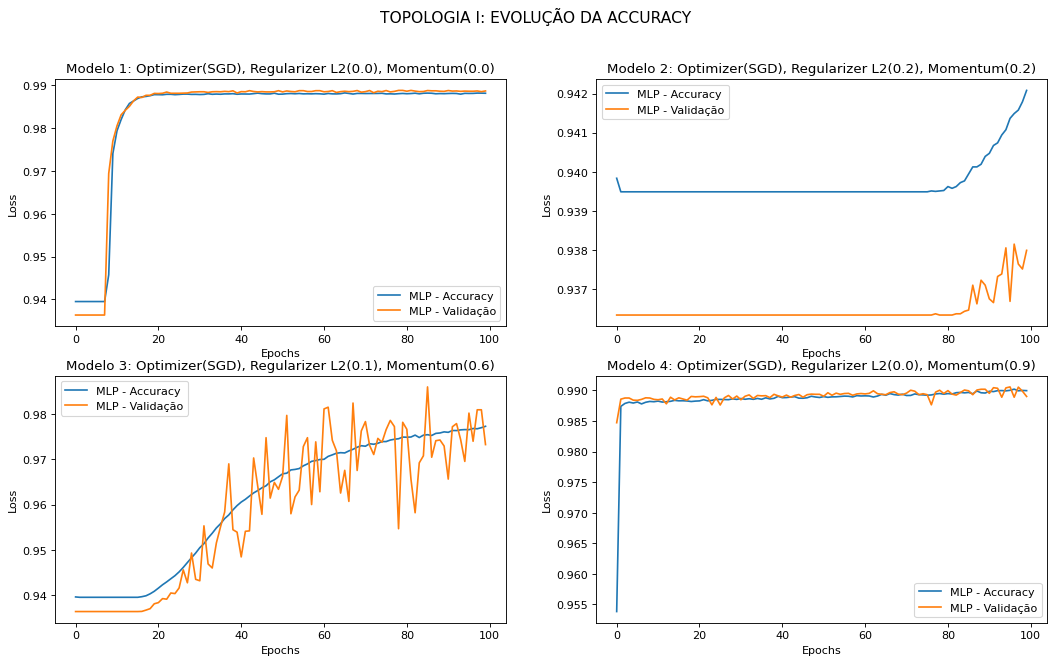

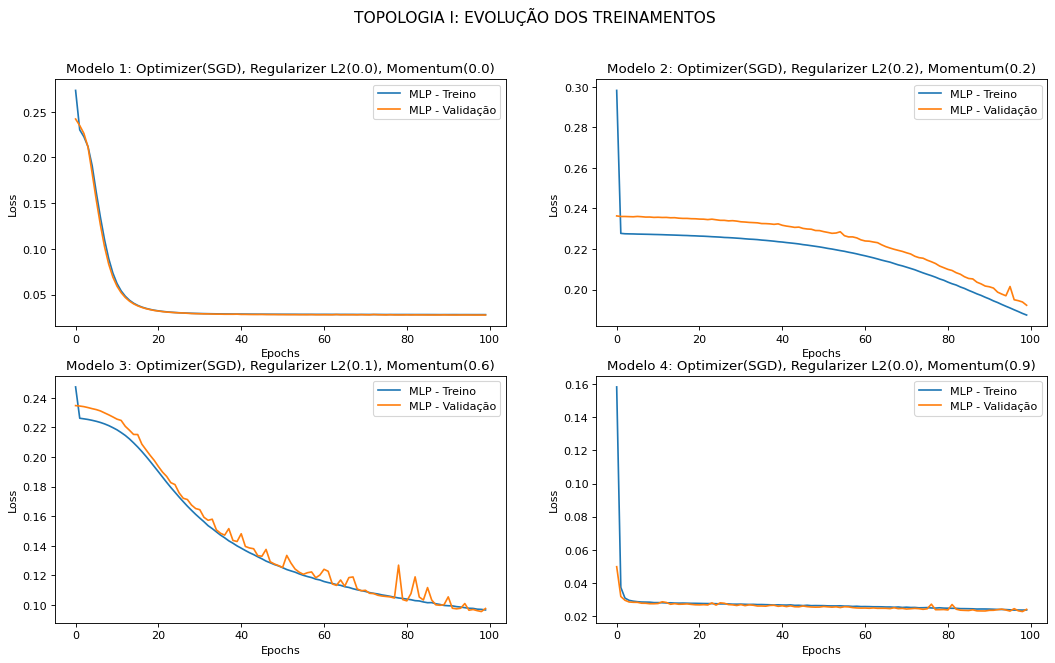

In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA I: EVOLUÇÃO DA ACCURACY', size=14)
for res in range(0,4):
    plt.subplot(2,2,res+1)
    plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(hist_mdl_tpl_I_classif[res].history['accuracy'], label="MLP - Accuracy")
    plt.plot(hist_mdl_tpl_I_classif[res].history['val_accuracy'], label="MLP - Validação")
    plt.legend()
plt.show()

figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA I: EVOLUÇÃO DOS TREINAMENTOS', size=14)
for res in range(0,4):
    plt.subplot(2,2,res+1)
    plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(hist_mdl_tpl_I_classif[res].history['loss'], label="MLP - Treino")
    plt.plot(hist_mdl_tpl_I_classif[res].history['val_loss'], label="MLP - Validação")
    plt.legend()
plt.show()

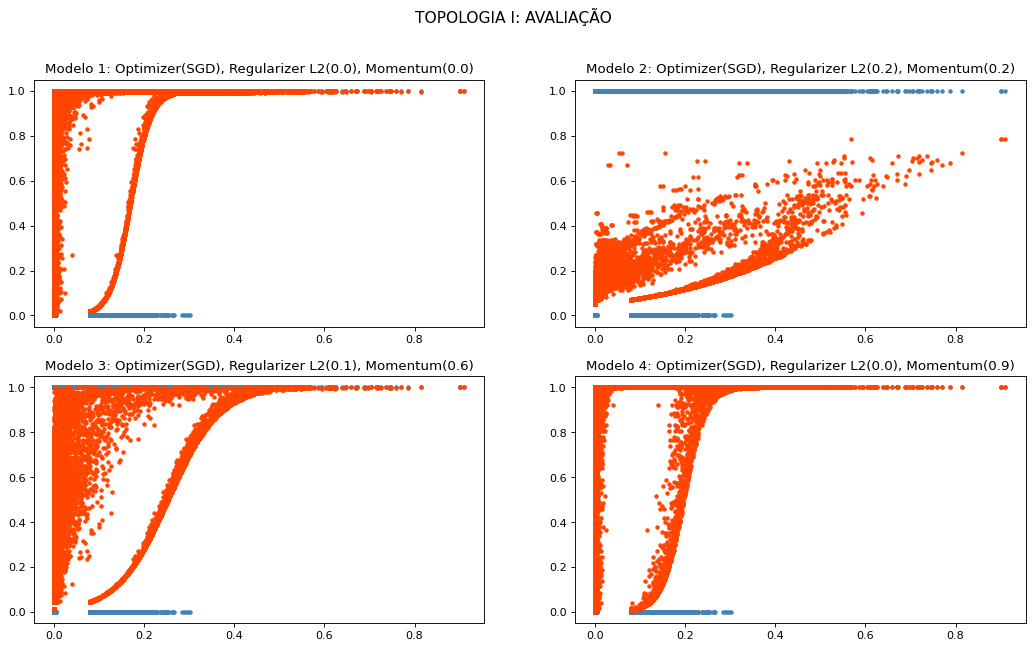

983/983 [==============================] - 2s 2ms/step - loss: 0.0241 - accuracy: 0.9890


In [ ]:
# Agora vamos transformar a saida da rede neural para a plotagem
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA I: AVALIAÇÃO', size=14)
for res in range(0,4):
  plt.subplot(2,2,res+1)
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  saida_rede = mdl_tpl_I_classif[res].predict(x_test_rain)
  plt.plot(x_test_rain, y_test_rain,  '.', color='#4682B4', label="MLP - Calculada")
  plt.plot(x_test_rain, saida_rede,  '.' ,color='#FF4500', label="MLP - Saída de rede")
  #plt.xlabel("tempo")
  #plt.ylabel("tensão")
plt.show()




for res in range(0,4):
  test_loss = mdl_tpl_I_classif[res].evaluate(x_test_rain, y_test_rain)



---



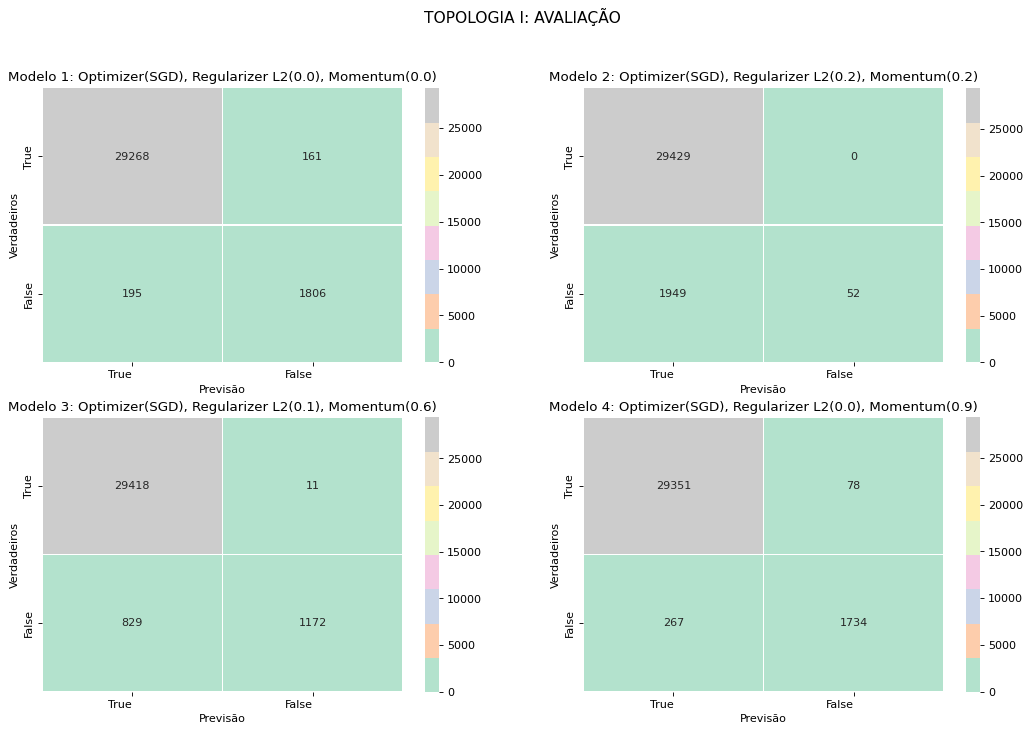

In [ ]:
figure(figsize=(16,10),dpi=80)
plt.suptitle('TOPOLOGIA I: AVALIAÇÃO', size=14)
for res in range(0,4):

  plt.subplot(2,2,res+1)
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  confusionMatrixDF = pd.DataFrame(confusion_matrix(y_test_rain, np.round(mdl_tpl_I_classif[res].predict(x_test_rain))),
                                  index=('True', 'False'), 
                                  columns=('True', 'False'))
  heatmap = sns.heatmap(confusionMatrixDF, annot=True, fmt="d", cmap="Pastel2", linewidths=0.1, vmin=0)
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),  ha='right')
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right')
  plt.ylabel('Verdadeiros')
  plt.xlabel('Previsão')
plt.show()




---



## **Topologia II**

A rede neural que será criada será uma MLP com 4 camadas, sendo:
*   01 camada de entrada (input layer) com 10 Neurônios
*   01 camada escondida (hidden layer) com 10 Neurônios
*   01 camada escondida (hidden layer) com 5 Neurônios
*   01 camada de saída (output layer) com 1 Neurônio



---



**Criação dos modelos**

In [ ]:
#Modelos da Topologia II
mdl_tpl_II_classif = []

for res in range(0,4):
  #print(i)
  sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=momentum[res])
  mdl_tpl_II_classif.append(Sequential())
  mdl_tpl_II_classif[res].add(Dense(10, input_dim=x_train_rain.shape[1], kernel_regularizer=l2(regularizer[res]),activation='relu'))
  mdl_tpl_II_classif[res].add(Dense(10, kernel_regularizer=l2(regularizer[res]), activation="relu"))
  mdl_tpl_II_classif[res].add(Dense(5, kernel_regularizer=l2(regularizer[res]), activation="relu"))
  mdl_tpl_II_classif[res].add(Dense(1, activation="sigmoid"))
  mdl_tpl_II_classif[res].compile(loss='binary_crossentropy', optimizer=sgd, metrics=["accuracy"])



**Agora vamos treinar os Modelos criados**

In [ ]:
hist_mdl_tpl_II_classif = []
for res in range(0,4):
  hist_mdl_tpl_II_classif.append(
    mdl_tpl_II_classif[res].fit(x_train_rain.values, y_train_rain.values, epochs=epochs, batch_size=32, 
                               validation_data=(x_test_rain.values,  y_test_rain.values), verbose=1, shuffle=True))
  


**Resultados do Treinamento e accuracy**

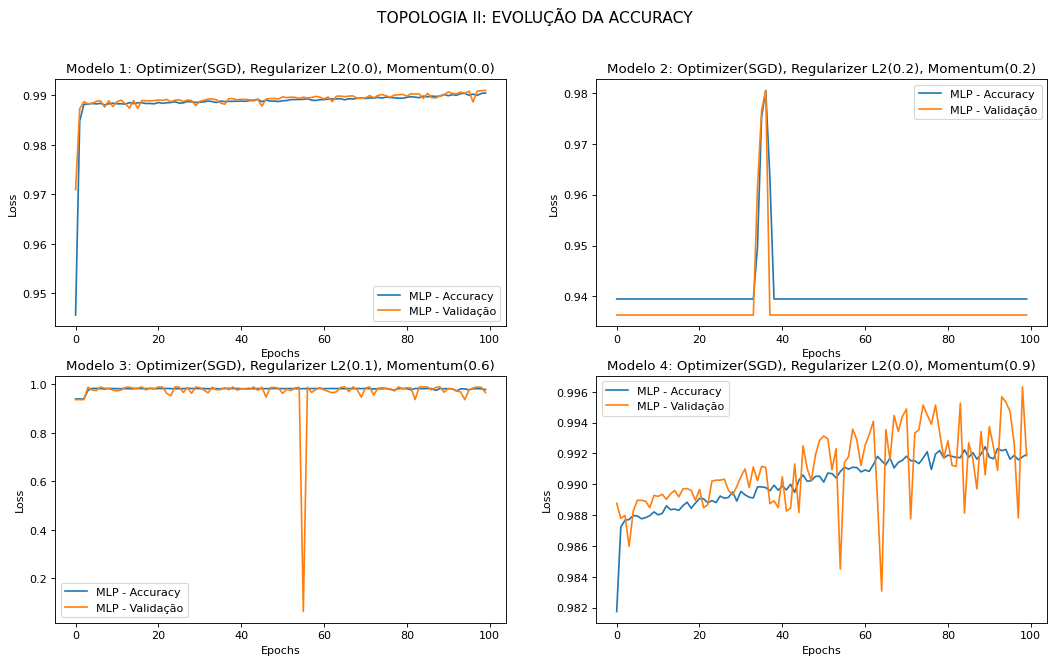

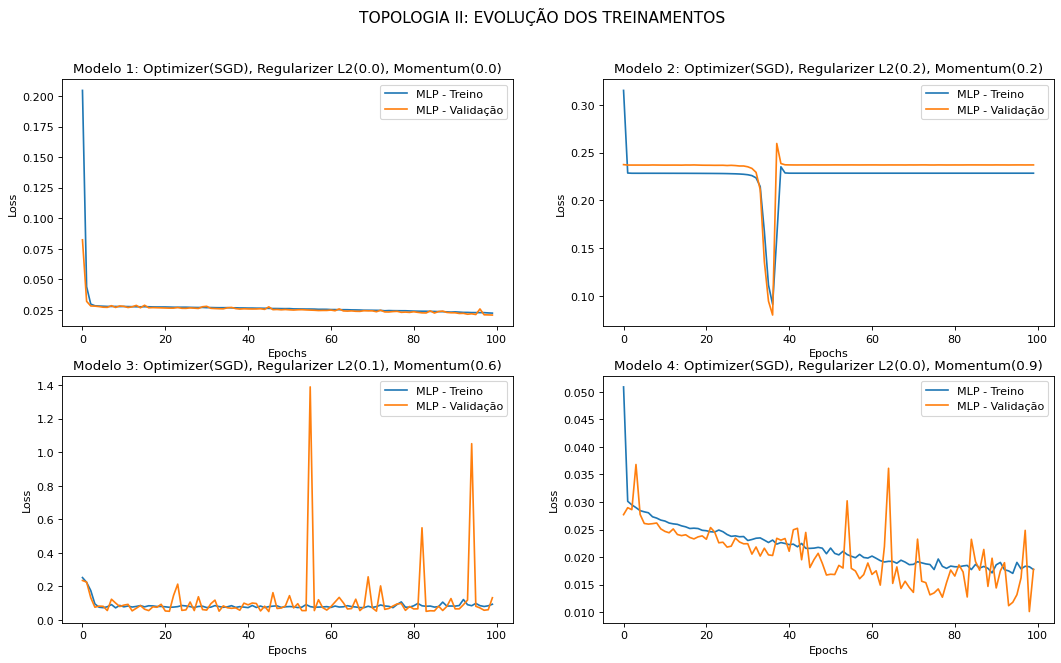

In [ ]:
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA II: EVOLUÇÃO DA ACCURACY', size=14)
for res in range(0,4):
    plt.subplot(2,2,res+1)
    plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(hist_mdl_tpl_II_classif[res].history['accuracy'], label="MLP - Accuracy")
    plt.plot(hist_mdl_tpl_II_classif[res].history['val_accuracy'], label="MLP - Validação")
    plt.legend()
plt.show()

figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA II: EVOLUÇÃO DOS TREINAMENTOS', size=14)
for res in range(0,4):
    plt.subplot(2,2,res+1)
    plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(hist_mdl_tpl_II_classif[res].history['loss'], label="MLP - Treino")
    plt.plot(hist_mdl_tpl_II_classif[res].history['val_loss'], label="MLP - Validação")
    plt.legend()
plt.show()

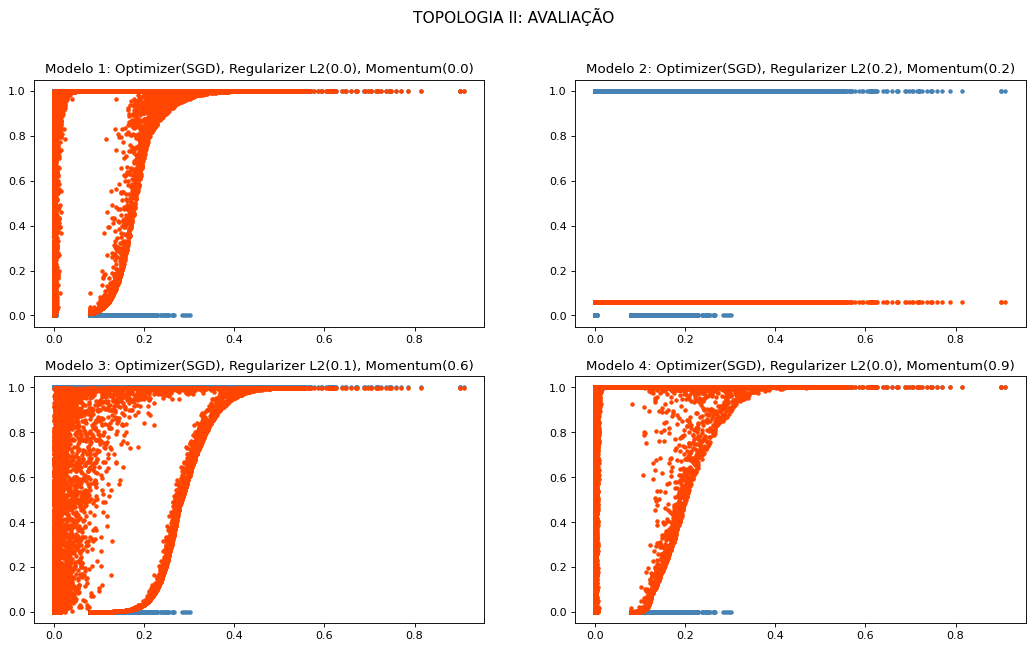

983/983 [==============================] - 2s 2ms/step - loss: 0.0178 - accuracy: 0.9919


In [ ]:
# Agora vamos transformar a saida da rede neural para a plotagem
figure(figsize=(16,9),dpi=80)
plt.suptitle('TOPOLOGIA II: AVALIAÇÃO', size=14)
for res in range(0,4):
  plt.subplot(2,2,res+1)
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  saida_rede = mdl_tpl_II_classif[res].predict(x_test_rain)
  plt.plot(x_test_rain, y_test_rain,  '.', color='#4682B4', label="MLP - Calculada")
  plt.plot(x_test_rain, saida_rede,  '.' ,color='#FF4500', label="MLP - Saída de rede")
  #plt.xlabel("tempo")
  #plt.ylabel("tensão")
plt.show()




for res in range(0,4):
  test_loss = mdl_tpl_II_classif[res].evaluate(x_test_rain, y_test_rain)



---



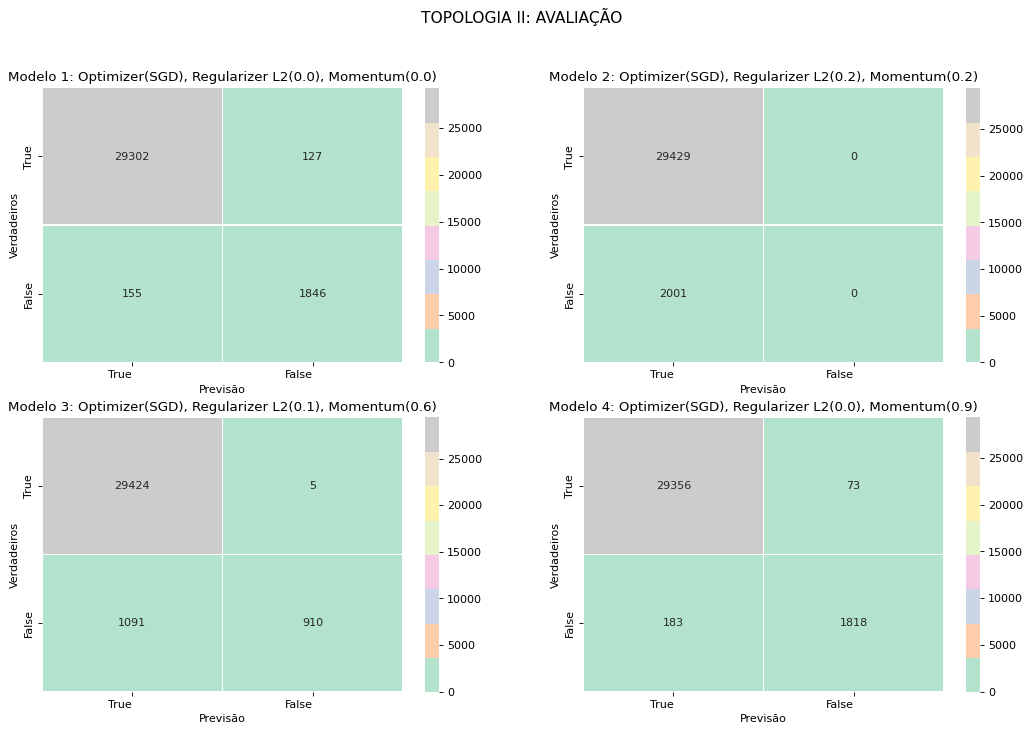

In [ ]:
figure(figsize=(16,10),dpi=80)
plt.suptitle('TOPOLOGIA II: AVALIAÇÃO', size=14)
for res in range(0,4):

  plt.subplot(2,2,res+1)
  plt.title('Modelo '+ str(res+1) + ': Optimizer(SGD), Regularizer L2('+str(regularizer[res])+'), Momentum('+str(momentum[res])+')')
  confusionMatrixDF = pd.DataFrame(confusion_matrix(y_test_rain, np.round(mdl_tpl_II_classif[res].predict(x_test_rain))),
                                  index=('True', 'False'), 
                                  columns=('True', 'False'))
  heatmap = sns.heatmap(confusionMatrixDF, annot=True, fmt="d", cmap="Pastel2", linewidths=0.1, vmin=0)
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),  ha='right')
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right')
  plt.ylabel('Verdadeiros')
  plt.xlabel('Previsão')
plt.show()


## **Topologia III**



---



## **Topologia IV**



---



## **Topologia V**



---



#  **Considerações Finais**

As redes MLP são uma boa opção para ser aplicada em problemas de classificação e de regressão. Com base nos históricos obtidos nos treinamentos e testes em cada uma das topologias, aplicando a variação nos hyperparâmetros, número de camadas e números de neurônios, foi  possível visualizar qual a melhor configuração e melhor modelo para ser apicado ao problema em questão.

# **Referências**

BASHEER, I. A.; HAJMEER, M. Artificial neural networks: fundamentals, computing, design, and application. Journal of Microbiological Methods, v. 43, p. 3–31, 2000

HAYKIN, Simon. Redes Neurais : princípios e prática. Traduzido por Paulo Martins Engel. 2. ed. Porto Alegre : Bookman, 2001. 900 p. il.

HSU, K. L.; GAO, X.; SOROOSHIAN, S.; GUPTA, H. V. Precipitation estimation from remotely sensed information using artificial neural networks. Journal of Applied Meteorology, v. 36, n. 9, p. 1176-1190, 1997.

https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8

https://sites.icmc.usp.br/andre/research/neural/MLP.htm

KOVAKS, Z. L. Redes Neurais Artificiais: fundamentos e Aplicações. São Paulo: Acadêmica, 1996.

TAFNER, Malcon A.; XEREZ, Marcos de; RODRIGUES FILHO, Ilson W. Redes neurais artificiais : introdução e princípios de neurocomputação. Blumenau : Eko, 1995.

Hinton, Geoffrey, Nitish Srivastava, and Kevin Swersky. “Neural Networks for Machine Learning Lecture 6a Overview of Mini--Batch Gradient Descent,” 2012.
